In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ppmilib
import ppmilib.utils
import ppmilib.updrs3
import ppmilib.cognitive
from ppmilib.datadictionary import DataDictionary

In [2]:
# Load in all the patient data and limit it to Enrolled status only
pat_df = ppmilib.utils.fetch_ppmi_data_file("Patient_Status.csv", "subject")
pat_df = pat_df[pat_df.ENROLL_STATUS == "Enrolled"]
pat_df = pat_df[["PATNO", "ENROLL_CAT", "DESCRP_CAT"]]

print(pat_df.shape)

(1654, 3)


In [3]:
# Load in Demographics data
demo_df = ppmilib.utils.fetch_ppmi_data_file("Screening___Demographics.csv", "subject")
demo_df["AGE"] = 2018 - demo_df["BIRTHDT"]

In [4]:
# Load in UPDRS Part III variables
updrs3_df = ppmilib.updrs3.fetch_updrs_3_file()
updrs3_df.shape

(1775, 51)

In [5]:
subscore_colnames = ppmilib.updrs3.extract_subscore_column_names(updrs3_df)
updrs3_df["UPDRS3TOT"] = updrs3_df[subscore_colnames].sum(axis=1)
np.all(updrs3_df.PATNO.duplicated() == False) #Check that there are no duplicates

True

In [6]:
updrs3_df = updrs3_df[["PATNO", "UPDRS3TOT"]]

In [7]:
df = pd.merge(pat_df, demo_df, on="PATNO", how="inner")
df = pd.merge(df, updrs3_df, on="PATNO", how="inner")

In [8]:
# Need to do some weird stuff with NA values to make get the full crosstab!
pd.crosstab(df.ENROLL_CAT.fillna(' NaN'), df.DESCRP_CAT.fillna(' NaN'), dropna=False, margins=True)

DESCRP_CAT,NaN,GBA+,GBA-,HYP,LRRK2+,LRRK2-,RBD,SNCA+,All
ENROLL_CAT,,,,,,,,,
GENPD,0,64,0,0,134,0,0,19,217
GENUN,0,122,0,0,181,1,0,6,310
HC,169,0,0,0,0,0,0,0,169
PD,360,0,0,0,0,0,0,0,360
PRODROMA,0,0,0,23,0,0,37,0,60
REGPD,0,52,0,0,148,0,0,4,204
REGUN,0,103,1,0,143,10,0,4,261
SWEDD,55,0,0,0,0,0,0,0,55
All,584,341,1,23,606,11,37,33,1636


    * We want to select the GBA+ category in GENPD
    * We want to match the above popluation with the PD population

In [9]:
# Create a BUCKET variable which is EMPTY except in our populations of interest
df["BUCKET"] = "EMPTY"
df.loc[(df.ENROLL_CAT == "GENPD") & (df.DESCRP_CAT == "GBA+"), "BUCKET"] = "GBA+"
df.loc[(df.ENROLL_CAT == "PD"), "BUCKET"] = "PD"
df_pop = df[df.BUCKET != "EMPTY"]

# df_pop now has the populations of interest together with the matching variables
df_pop = df_pop[["PATNO", "AGE", "GENDER", "UPDRS3TOT", "BUCKET"]]

match_vars = df_pop.columns

df_pop.head()

,PATNO,AGE,GENDER,UPDRS3TOT,BUCKET
17,3001,72.0,2.0,12.0,PD
18,3002,75.0,1.0,17.0,PD
19,3003,64.0,1.0,29.0,PD
23,3010,54.0,2.0,19.0,PD
24,3012,65.0,2.0,20.0,PD


In [10]:
# Fetch all the cognitive variables of interest

benton_df = ppmilib.cognitive.fetch_benton_judgement_line_orientation()
hvlt_df = ppmilib.cognitive.fetch_hopkins_verbal_learning_test()
lns_df = ppmilib.cognitive.fetch_letter_number_sequencing()
sem_df = ppmilib.cognitive.fetch_semantic_fluency()
sdm_df = ppmilib.cognitive.fetch_symbol_digit_modalities()

moca_df = ppmilib.cognitive.fetch_moca_assesment(keep_important_cols_only=False)
moca_df = moca_df[["PATNO"] + [col for col in moca_df.columns if col.startswith("MCA")]]

df_pop = pd.merge(df_pop, benton_df, how="left", on="PATNO")
df_pop = df_pop.merge(hvlt_df, how="left", on="PATNO")
df_pop = df_pop.merge(lns_df, how="left", on="PATNO")
df_pop = df_pop.merge(sem_df, how="left", on="PATNO")
df_pop = df_pop.merge(sdm_df, how="left", on="PATNO")
df_pop = pd.merge(df_pop, moca_df, how="left", on="PATNO")

df_pop.head()

,PATNO,AGE,GENDER,UPDRS3TOT,BUCKET,BJLOT,HVLTRDLY,HVLTREC,HVLT_IR,HVLT_DR,...,MCAREC3,MCAREC4,MCAREC5,MCADATE,MCAMONTH,MCAYR,MCADAY,MCAPLACE,MCACITY,MCATOT
0,3001,72.0,2.0,12.0,PD,15.0,12.0,12.0,27.0,10.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0
1,3002,75.0,1.0,17.0,PD,13.0,11.0,12.0,28.0,9.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0
2,3003,64.0,1.0,29.0,PD,13.0,11.0,12.0,29.0,11.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
3,3010,54.0,2.0,19.0,PD,10.0,10.0,11.0,25.0,10.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.0
4,3012,65.0,2.0,20.0,PD,14.0,8.0,12.0,24.0,10.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.0


In [11]:
data_dict = DataDictionary.create()
column_namesd = data_dict.get_column_dict("MOCA")
column_namesd.update(data_dict.get_column_dict("HVLT"))
column_namesd.update(data_dict.get_column_dict("SDM"))

column_namesd["BJLOT"] = "Benton Judgement of Line Orientation"
column_namesd["HVLT_IR"] = "Hopkins Verbal Learning Immediate Recall"
column_namesd["HVLT_DR"] = "Hopkins Verbal Learning Discriminant Recognition"
column_namesd["LNS_SUM"] = "Letter Number Sequencing"
column_namesd["SFT_SUM"] = "Semantic Fluency"

In [15]:
def plot_pair_violin_plot(var):
    g = sns.factorplot(x="BUCKET", y=var, data=df_pop, kind="violin")
    if var in column_namesd:
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(column_namesd[var])
    plt.show()

## Characteristics of the PD vs GBA+ population

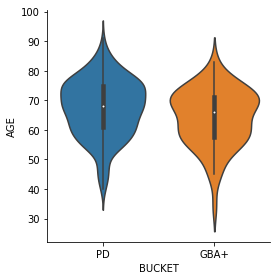

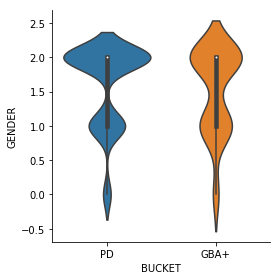

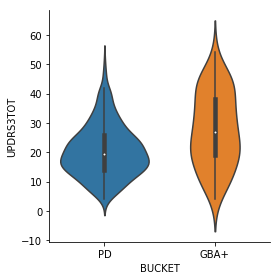

In [17]:
for var in df_pop.columns[1:4]:
    plot_pair_violin_plot(var)

The **GBA+** population looks a little bit younger but seems to have worse **UPDRS III** scores. 

For gender 2.0 is males and 1.0 / 0.0 are women. The two categories of women have to do with pregnancy. 

## Differences in some congnitive summary scores

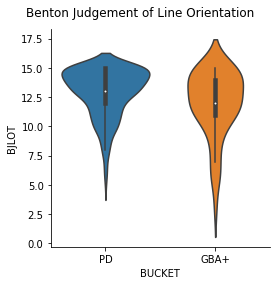

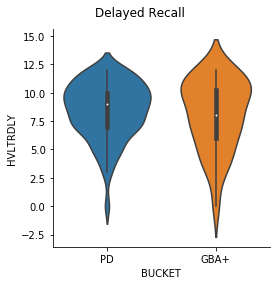

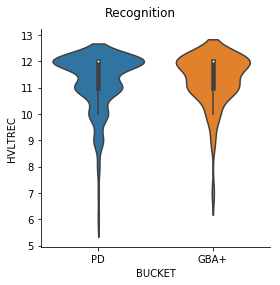

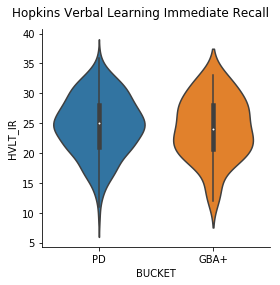

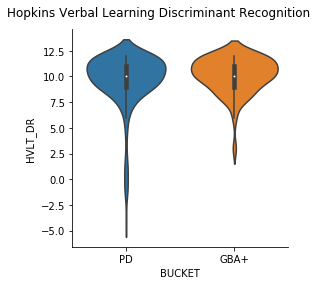

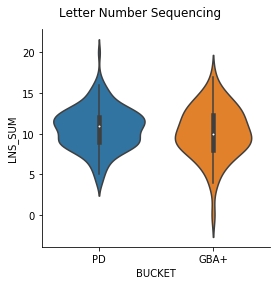

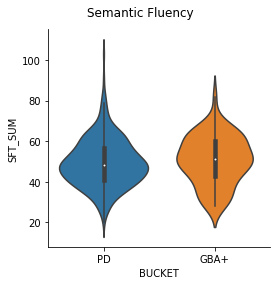

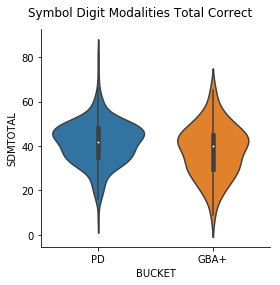

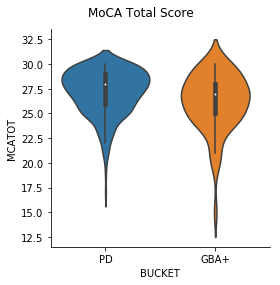

In [13]:
# plot a few cognitive test summary differences
for var in (list(df_pop.columns[5:13]) + ["MCATOT"]):
    plot_pair_violin_plot(var)

**GBA+** looks workse on Benton Judgement of Line Orientation, Delayed Recall, Immediate Recall, Letter Number Sequencing, MOCA Total Score. 

**GBA+** looks better on Semantic Fluency

## Differences in MOCA subscores

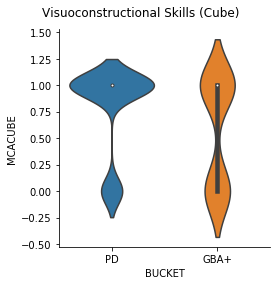

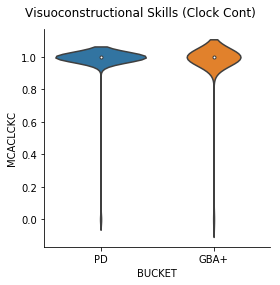

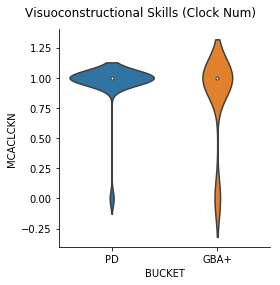

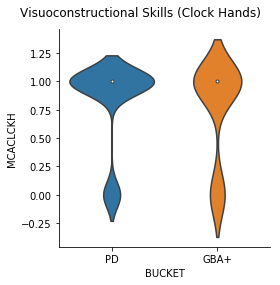

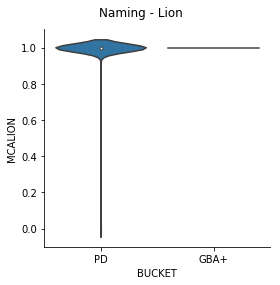

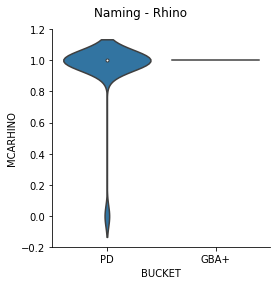

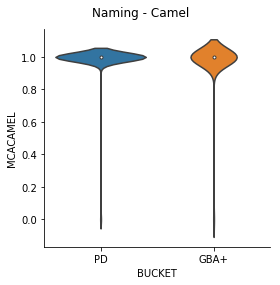

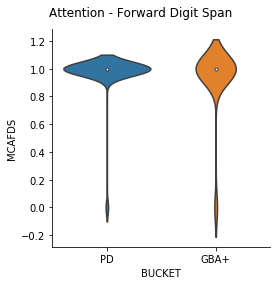

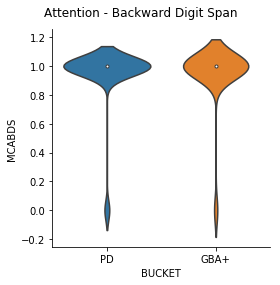

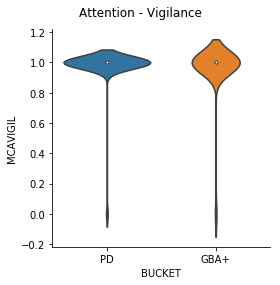

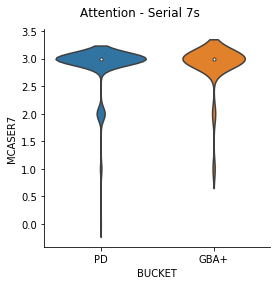

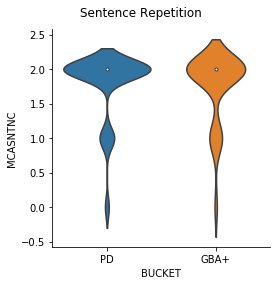

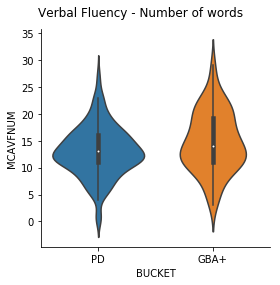

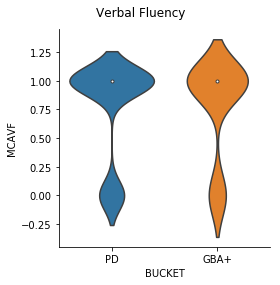

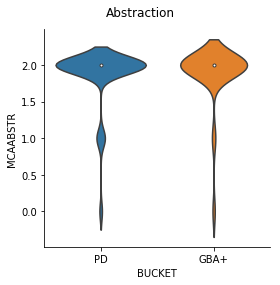

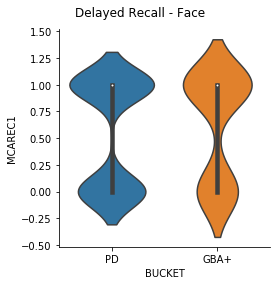

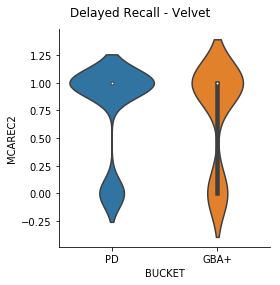

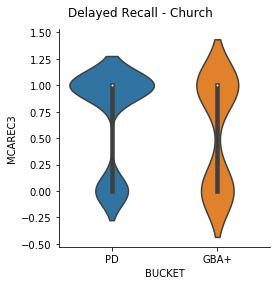

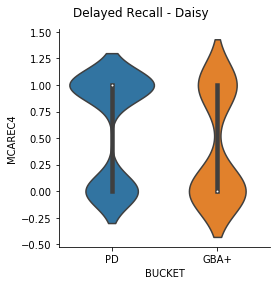

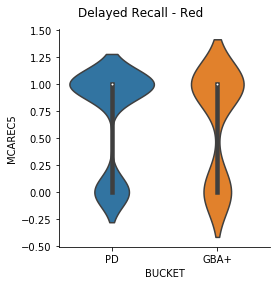

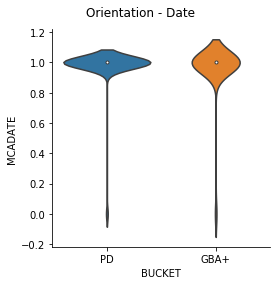

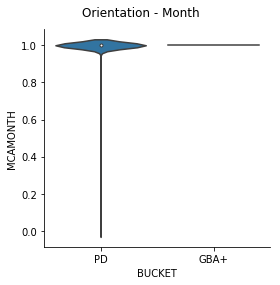

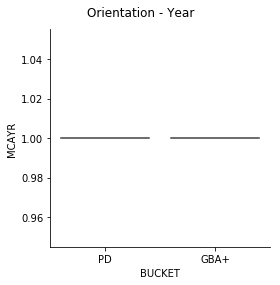

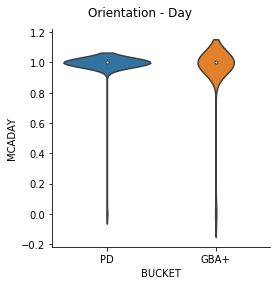

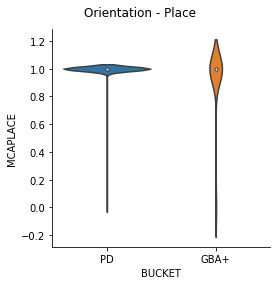

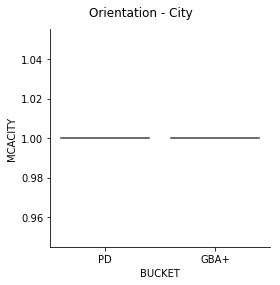

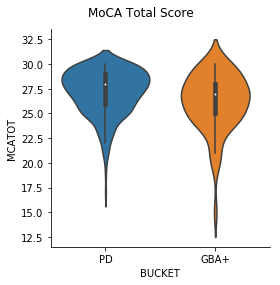

In [14]:
# plot the MOCA cognitive test differences
for var in df_pop.columns[14:]:
    plot_pair_violin_plot(var)